In [2]:
# =============================
# 1. INSTALAR Y CARGAR LIBRERÍAS
# =============================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
# =============================
# 2. SUBIR ARCHIVO
# =============================
from google.colab import files
uploaded = files.upload()

# =============================
# 3. CARGAR EL ARCHIVO
# =============================
df = pd.read_excel(next(iter(uploaded)))
df.head()

Saving dataset_entrenamiento_500.xlsx to dataset_entrenamiento_500 (1).xlsx


,juego_id,tiempo_juego,frutas_mostradas,errores_10s,aciertos_10s,vidas_restantes,velocidad_actual,fruta_dominante,errores_fruta,accion
0,1,10,3,2,1,1,3.0,0,0,mantener
1,1,20,3,0,3,1,3.0,0,0,aumentar_velocidad
2,1,30,4,1,3,0,2.5,2,1,aumentar_velocidad
3,2,10,3,2,1,1,3.0,3,2,mantener
4,2,20,3,0,3,1,3.0,2,0,aumentar_velocidad


In [4]:
# =============================
# 4. PREPROCESAMIENTO
# =============================
# Eliminar 'juego_id' y separar X, y
X = df.drop(columns=["accion", "juego_id"])
y = df["accion"]

# Codificar y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [5]:
# =============================
# 5. ENTRENAR MODELO
# =============================
modelo = DecisionTreeClassifier(random_state=42)
modelo.fit(X_train, y_train)

# =============================
# 6. EVALUAR MODELO
# =============================
y_pred = modelo.predict(X_test)
print("=== REPORT ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred))


=== REPORT ===
                    precision    recall  f1-score   support

aumentar_velocidad       0.91      0.93      0.92        46
          mantener       0.94      0.93      0.93        54

          accuracy                           0.93       100
         macro avg       0.93      0.93      0.93       100
      weighted avg       0.93      0.93      0.93       100

=== MATRIZ DE CONFUSIÓN ===
[[43  3]
 [ 4 50]]


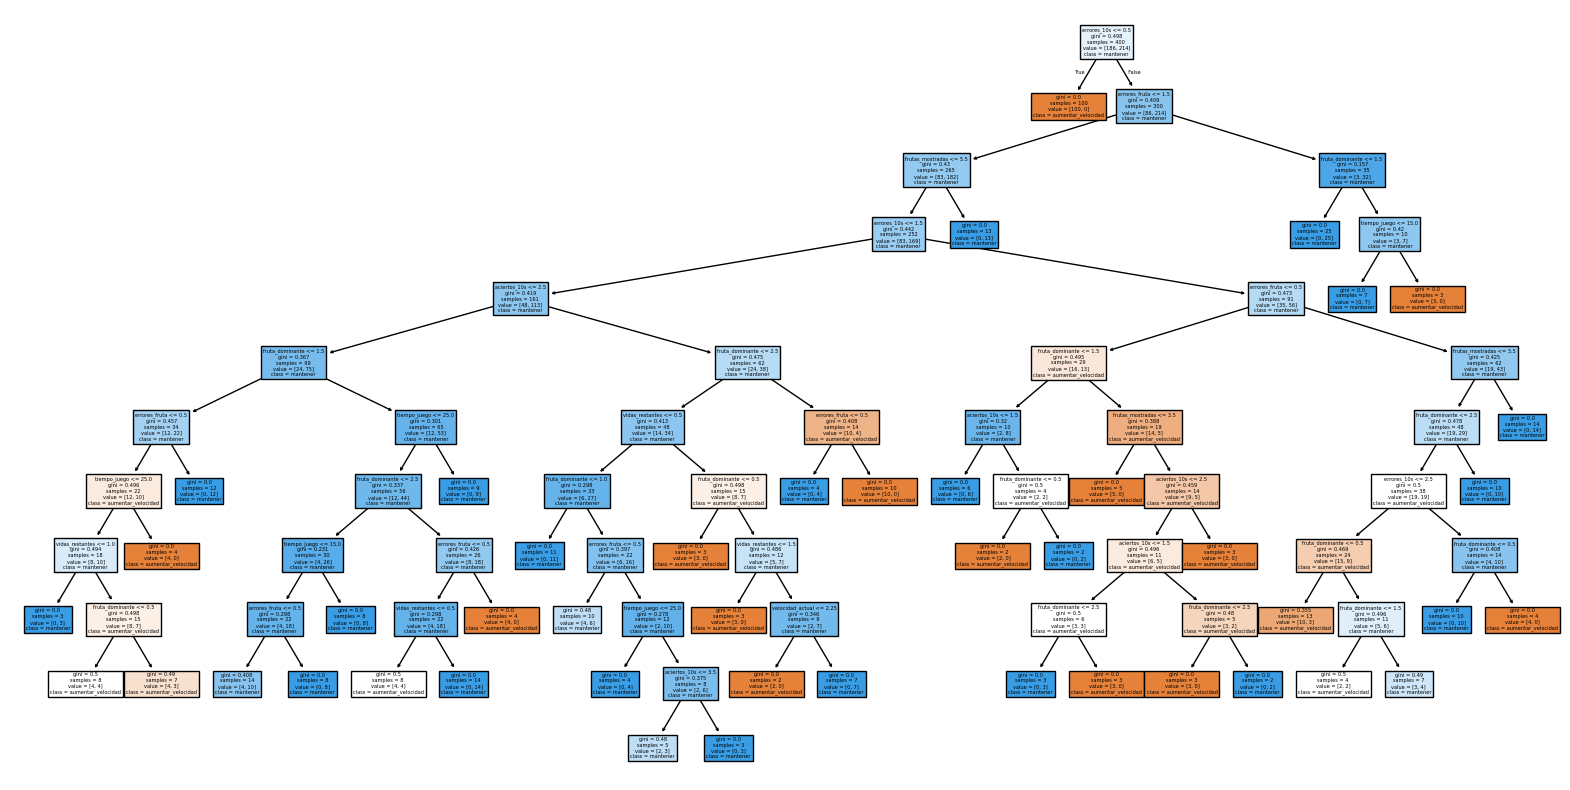

In [6]:
# =============================
# 7. VISUALIZAR ÁRBOL
# =============================
plt.figure(figsize=(20, 10))
plot_tree(modelo, feature_names=X.columns, class_names=le.classes_, filled=True)
plt.show()

In [7]:
# =============================
# 8. GUARDAR MODELO Y ENCODER
# =============================
joblib.dump(modelo, "arbol_decision_modelo.pkl")
joblib.dump(le, "label_encoder_accion.pkl")


['label_encoder_accion.pkl']

In [16]:
# Simulación en tiempo real con refuerzo y modelo entrenado

import pandas as pd
import joblib
import random
import time

# Cargar modelo y codificador
modelo = joblib.load("arbol_decision_modelo.pkl")
le = joblib.load("label_encoder_accion.pkl")

# Configuración inicial
frutas = ['aguacate', 'sandia', 'uva', 'naranja']
frutas_codificadas = {fruta: i for i, fruta in enumerate(frutas)}
vidas = 3
tiempo_total = 0
velocidad_actual = 3.0
historial_errores = {fruta: 0 for fruta in frutas}

print("\n🎮 Iniciando juego con refuerzo y simulación en tiempo real...\n")

for ciclo in range(20):
    if vidas == 0:
        print("💀 Juego terminado por falta de vidas.")
        break

    tiempo_total += 10
    frutas_en_10s = int(10 / velocidad_actual)
    errores_bloque = 0
    aciertos_bloque = 0
    fruta_dominante = None
    max_errores = -1

    print(f"\n🔄 Bloque de 10 segundos | Velocidad: {velocidad_actual}s por fruta | Frutas: {frutas_en_10s}")

    for _ in range(frutas_en_10s):
        total_errores = sum(historial_errores.values())
        if total_errores == 0:
            fruta = random.choice(frutas)
        else:
            pesos = [historial_errores[f] + 1 for f in frutas]
            fruta = random.choices(frutas, weights=pesos)[0]

        resultado = random.choices(['correcto', 'incorrecto', 'no_aplastada'], weights=[0.7, 0.2, 0.1])[0]
        print(f"Fruta mostrada: {fruta} → Resultado: {resultado}")

        if resultado in ['incorrecto', 'no_aplastada']:
            historial_errores[fruta] += 1
            errores_bloque += 1
            vidas -= 1
        else:
            aciertos_bloque += 1

        if historial_errores[fruta] > max_errores:
            fruta_dominante = frutas_codificadas[fruta]
            max_errores = historial_errores[fruta]

        if vidas == 0:
            print("💔 Te has quedado sin vidas.")
            break

        time.sleep(velocidad_actual)

    fruta_dominante = fruta_dominante if fruta_dominante is not None else 0
    errores_fruta = max_errores if max_errores >= 0 else 0

    entrada = pd.DataFrame([[
        tiempo_total, frutas_en_10s, errores_bloque, aciertos_bloque, vidas,
        velocidad_actual, fruta_dominante, errores_fruta
    ]], columns=[
        'tiempo_juego', 'frutas_mostradas', 'errores_10s', 'aciertos_10s',
        'vidas_restantes', 'velocidad_actual', 'fruta_dominante', 'errores_fruta']
    )

    pred = modelo.predict(entrada)[0]
    accion = le.inverse_transform([pred])[0]

    print(f"\n✅ Resultados del bloque:")
    print(f"Aciertos: {aciertos_bloque} | Errores: {errores_bloque} | Vidas restantes: {vidas} | Acción del modelo: {accion}")

    if accion == 'aumentar_velocidad':
        velocidad_actual = max(1.0, velocidad_actual - 0.5)

    time.sleep(2)  # Pausa entre bloques

print("\n🏁 Juego finalizado.")



🎮 Iniciando juego con refuerzo y simulación en tiempo real...


🔄 Bloque de 10 segundos | Velocidad: 3.0s por fruta | Frutas: 3
Fruta mostrada: aguacate → Resultado: correcto
Fruta mostrada: naranja → Resultado: correcto
Fruta mostrada: uva → Resultado: no_aplastada

✅ Resultados del bloque:
Aciertos: 2 | Errores: 1 | Vidas restantes: 2 | Acción del modelo: mantener

🔄 Bloque de 10 segundos | Velocidad: 3.0s por fruta | Frutas: 3
Fruta mostrada: aguacate → Resultado: correcto
Fruta mostrada: naranja → Resultado: correcto
Fruta mostrada: uva → Resultado: correcto

✅ Resultados del bloque:
Aciertos: 3 | Errores: 0 | Vidas restantes: 2 | Acción del modelo: aumentar_velocidad

🔄 Bloque de 10 segundos | Velocidad: 2.5s por fruta | Frutas: 4
Fruta mostrada: uva → Resultado: correcto
Fruta mostrada: uva → Resultado: correcto
Fruta mostrada: uva → Resultado: correcto
Fruta mostrada: naranja → Resultado: correcto

✅ Resultados del bloque:
Aciertos: 4 | Errores: 0 | Vidas restantes: 2 | Acción 